In [276]:
import os
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing
import os
import torch
import numpy as np
import cv2  # OpenCV for image processing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [277]:
image_size_full = 256 #256 full in 768

In [278]:
import torch

class Patcher:
    """Class to patch and unpatch data for image segmentation tasks.
    
    Args:
        patch_shape (tuple of ints): Patch size for the image (e.g., (258, 258)).
    """

    def __init__(self, patch_shape):
        assert len(patch_shape) == 2, "This implementation supports 2D images only."
        self.patch_shape = patch_shape

    def patch(self, data):
        """Splits image data into patches. Applies reflection padding if the image dimensions
        are not divisible by the patch size.

        Args:
            data (torch.Tensor): Image tensor of shape (channels, height, width).
        
        Returns:
            patches (torch.Tensor): Patched image tensor of shape (num_patches, channels, patch_height, patch_width).
            original_shape (tuple): The original shape of the image before padding.
        """
        assert data.ndim == 3, "Input data must be 3D (channels, height, width)."

        # Extract image dimensions
        channels, height, width = data.shape
        patch_height, patch_width = self.patch_shape

        # Calculate necessary padding to ensure patches fit
        pad_height, pad_width = self.get_padding((height, width))
        padding = (0, pad_width, 0, pad_height)  # Padding in (left, right, top, bottom)

        # Apply reflection padding to the image
        padded = torch.nn.functional.pad(data, padding, mode="reflect")
        
        # Unfold the image to create patches
        patches = torch.nn.functional.unfold(
            padded.unsqueeze(0), kernel_size=self.patch_shape, stride=self.patch_shape
        )
        # Reshape patches to (num_patches, channels, patch_height, patch_width)
        patches = patches.reshape(channels, patch_height, patch_width, -1).permute(3, 0, 1, 2)

        # Return patches and the original image shape for unpatching
        return patches, (height, width)

    def unpatch(self, patches, original_shape):
        """Reconstructs the original image from patches.

        Args:
            patches (torch.Tensor): Tensor of shape (num_patches, channels, patch_height, patch_width).
            original_shape (tuple): The original shape (height, width) of the image before patching.
        
        Returns:
            unpatched_image (torch.Tensor): The reconstructed image of shape (channels, height, width).
        """
        height, width = original_shape
        patch_height, patch_width = self.patch_shape

        # Calculate the necessary padding (to remove after unpatching)
        pad_height, pad_width = self.get_padding((height, width))
        padded_shape = (height + pad_height, width + pad_width)

        # Reshape patches for fold operation
        num_patches, channels, _, _ = patches.shape
        patches = patches.permute(1, 2, 3, 0).reshape(1, -1, num_patches)

        # Fold the patches back into the padded image
        padded_image = torch.nn.functional.fold(
            patches, output_size=padded_shape, kernel_size=self.patch_shape, stride=self.patch_shape
        )

        # Remove padding to recover the original image shape
        unpatched_image = padded_image[0, :, :height, :width]
        
        return unpatched_image

    def get_padding(self, spatial_shape):
        """Calculates padding needed to ensure that the image can be split into patches.

        Args:
            spatial_shape (tuple): Shape (height, width) of the image.
        
        Returns:
            pad_height (int): The padding to apply to the height.
            pad_width (int): The padding to apply to the width.
        """
        height, width = spatial_shape
        patch_height, patch_width = self.patch_shape

        # Calculate padding required to ensure divisibility
        pad_height = (patch_height - (height % patch_height)) if (height % patch_height) != 0 else 0
        pad_width = (patch_width - (width % patch_width)) if (width % patch_width) != 0 else 0

        return pad_height, pad_width


In [279]:
class SegmentationDataset(Dataset):
    def __init__(self, images_path, masks_path, target_size=(image_size_full, image_size_full), patch_size=(258, 258), augment=True):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.target_size = target_size
        self.patch_size = patch_size
        self.augment = augment

        # Inizializzazione del Patcher
        self.patcher = Patcher(self.patch_size)

        self.augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=5, p=0.5),
            A.RandomBrightnessContrast(p=0.1),
            A.GaussianBlur(blur_limit=1, p=0.1),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.1),
            A.CLAHE(clip_limit=1, p=0.1),
        ], additional_targets={'mask': 'image'})

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_path, self.image_files[idx])
        mask_path = os.path.join(self.masks_path, self.mask_files[idx])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.target_size is not None:
            # Resize image and mask
            image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        if self.augment:
            augmented = self.augmentations(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert image to float and normalize
        image = image.astype(np.float32) / 255.0
        
        # Convert mask to long and then to float32 for patching
        mask = self.transform_mask(mask).astype(np.float32)
        
        # Converti immagine e maschera in tensori
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # Add channel dimension

        # Applica patching a immagine e maschera
        patches_image, _ = self.patcher.patch(image_tensor)
        patches_mask, _ = self.patcher.patch(mask_tensor)

        # Per ogni patch, genera coords_intensities e labels
        coords_intensities_list = []
        labels_list = []
        for img_patch, mask_patch in zip(patches_image, patches_mask):
            coords_intensities, labels = self.generate_coords_intensities_and_labels(img_patch, mask_patch)
            coords_intensities_list.append(coords_intensities)
            labels_list.append(labels)

        # Concatena tutte le coords_intensities e labels
        coords_intensities = torch.cat(coords_intensities_list, dim=0)
        labels = torch.cat(labels_list, dim=0)

        return coords_intensities, labels

    def transform_mask(self, mask):
        mask_transformed = np.zeros_like(mask)
        mask_transformed[mask == 0] = 0
        mask_transformed[mask == 128] = 1
        mask_transformed[mask == 255] = 2
        return mask_transformed


    def generate_coords_intensities_and_labels(self, image_patch, mask_patch):
        C, H, W = image_patch.shape  # C è il canale, dovrebbe essere 1

        # Crea una griglia di coordinate
        y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
        coords = torch.stack((x_coords, y_coords), dim=-1).view(-1, 2)  # Forma: (H*W, 2)

        # Normalizza le coordinate
        coords = coords.float() / torch.tensor([W, H], dtype=torch.float32)

        # Ottieni intensità e label
        intensities = image_patch.view(-1, 1)  # Forma: (H*W, 1)
        labels = mask_patch.view(-1)  # Forma: (H*W,)

        # Combina coordinate e intensità
        coords_intensities = torch.cat([coords, intensities], dim=-1)  # Forma: (H*W, 3)

        return coords_intensities, labels



In [280]:
from torch.utils.data import DataLoader

def custom_collate(batch):
    coords_intensities_list, labels_list = zip(*batch)
    coords_intensities = torch.cat(coords_intensities_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return coords_intensities, labels


# Define paths to your image and mask directories (immagini intere, non patchate)
# images_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/training_images' 
# masks_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/training_masks'

images_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/patch_images' 
masks_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/patch_masks'


# Crea dataset e dataloader con immagini intere e patching dinamico
batch_size = 64    # Adjust based on your GPU memory
augment_bool = False

# Inizializza il dataset con patching dinamico
# dataset = SegmentationDataset(images_path, masks_path, target_size=(image_size_full, image_size_full), augment=augment_bool)
dataset = SegmentationDataset(images_path, masks_path, target_size=None, augment=augment_bool)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

# Preleva un batch di patch (immagini patchate e maschere patchate)
patches_image, patches_mask = next(iter(dataloader))

# Verifica le dimensioni delle patch caricate
print(patches_image.shape, patches_mask.shape)

torch.Size([4260096, 3]) torch.Size([4260096])


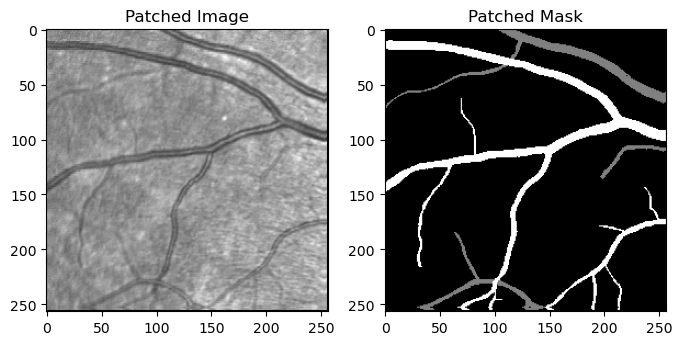

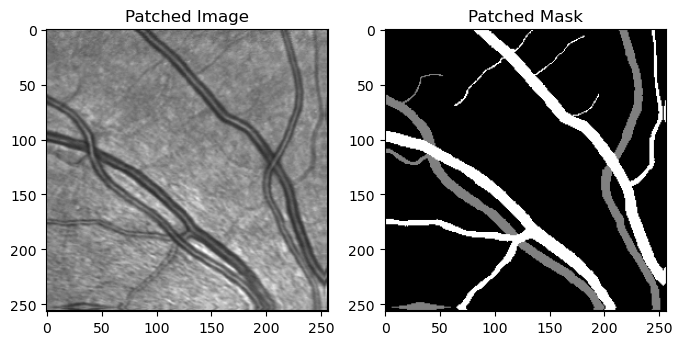

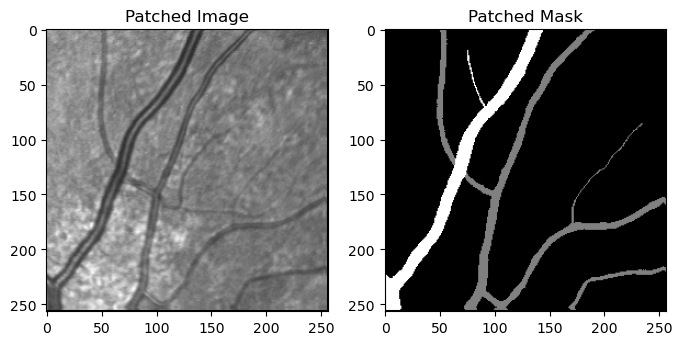

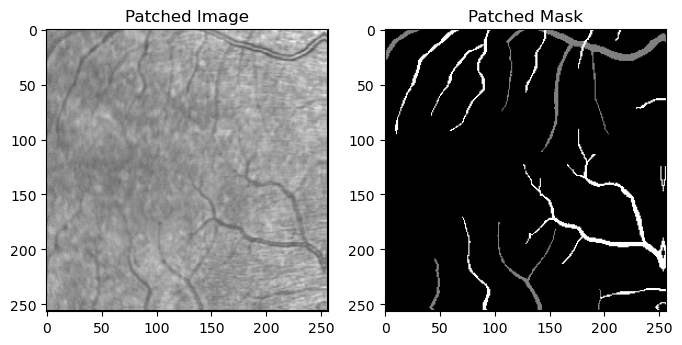

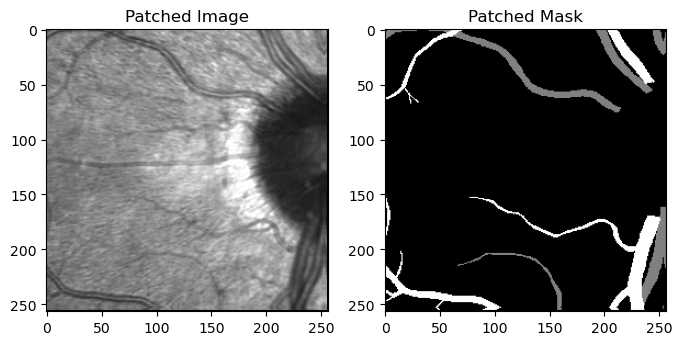

In [281]:
import matplotlib.pyplot as plt

def show_augmented_images(dataset, num_images=5):
    for i in range(num_images):
        coords_intensities, labels = dataset[i]
        
        # Estrai le coordinate, le intensità e le etichette
        coords = coords_intensities[:, :2]  # Shape: (N, 2)
        intensities = coords_intensities[:, 2]  # Shape: (N,)
        
        # Ricostruisci le dimensioni dell'immagine
        # Supponendo che le patch abbiano dimensioni fisse H x W
        # Devi conoscere H e W per poter ricostruire l'immagine
        # Se non conosci H e W, puoi ottenerli dalle coordinate massime
        H = int(coords[:, 1].max().item() * dataset.patch_size[0]) + 1
        W = int(coords[:, 0].max().item() * dataset.patch_size[1]) + 1
        
        # Ricostruisci l'immagine e la maschera
        image = torch.zeros((H, W))
        mask = torch.zeros((H, W))
        
        # Denormalizza le coordinate per ottenere gli indici dei pixel
        x_indices = (coords[:, 0] * (W - 1)).long()
        y_indices = (coords[:, 1] * (H - 1)).long()
        
        # Assegna le intensità e le etichette ai rispettivi pixel
        image[y_indices, x_indices] = intensities
        mask[y_indices, x_indices] = labels
        
        # Converti in NumPy per la visualizzazione
        image = image.numpy()
        mask = mask.numpy()
        
        # Visualizza l'immagine e la maschera
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Patched Image')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Patched Mask')
        plt.show()


# Visualizza alcune immagini patchate
show_augmented_images(dataset)


In [282]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, num_freqs):
        super(PositionalEncoding, self).__init__()
        self.num_freqs = num_freqs

    def forward(self, x):
        # x dovrebbe avere forma (N, num_coords)
        # print(f"PositionalEncoding input x shape: {x.shape}")  # Debug

        frequencies = torch.linspace(0, self.num_freqs - 1, self.num_freqs, device=x.device)
        frequencies = 2.0 ** frequencies  # Forma: (num_freqs,)
        # print(f"frequencies shape: {frequencies.shape}")  # Debug

        frequencies = frequencies.view(1, 1, -1)  # Forma: (1, 1, num_freqs)
        # print(f"frequencies after view: {frequencies.shape}")  # Debug

        x = x.unsqueeze(-1)  # Forma: (N, num_coords, 1)
        # print(f"x after unsqueeze(-1): {x.shape}")  # Debug

        x = x * frequencies  # Broadcasting, dovrebbe avere forma (N, num_coords, num_freqs)
        # print(f"x after multiplication: {x.shape}")  # Debug

        x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # Forma: (N, num_coords, num_freqs * 2)
        # print(f"x after sin and cos concatenation: {x.shape}")  # Debug

        x = x.view(x.shape[0], -1)  # Appiattisce in (N, num_coords * num_freqs * 2)
        # print(f"PositionalEncoding output x shape: {x.shape}")  # Debug

        return x


    
class AdaptiveDropout(nn.Module):
    def __init__(self, initial_p=0.5, decay_factor=0.95):
        super(AdaptiveDropout, self).__init__()
        self.p = initial_p
        self.decay_factor = decay_factor

    def forward(self, x):
        if self.training:
            return F.dropout(x, p=self.p, training=True)
        else:
            return x

    def step(self):
        self.p *= self.decay_factor  # Decrement dropout probability
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=1.0, is_last=False):
        super(SineLayer, self).__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

        self.is_last = is_last

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, x):
        # print(f"SineLayer input shape: {x.shape}")  # Aggiungi questa riga per il debug
        x = self.linear(x)
        x = torch.sin(self.omega_0 * x)

        if self.is_last is True: # ------------------> commentato
            # x = x + 0.5  # ------------------> commentato
            x = F.softmax(x, dim=-1)

        return x

class INRSegmentationModel(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=5, num_freqs=10, initial_dropout_p=0.5, outermost_linear=False, linear_network = False):
        super(INRSegmentationModel, self).__init__()
        self.num_classes = num_classes
        self.pos_enc = PositionalEncoding(num_freqs)

        # Calcola input_dim in base alla dimensione della codifica posizionale
        num_coords = 2  # Supponendo (x, y)
        input_dim = num_coords * num_freqs * 2  + 1  # +1 per l'intensità

        self.linear_network = linear_network
        self.outermost_linear = outermost_linear

        # print(f"INRSegmentationModel input_dim: {input_dim}, hidden_dim: {hidden_dim}")

        self.reduction_layer = nn.Linear(input_dim, hidden_dim)

        # self.dropouts = nn.ModuleList([AdaptiveDropout(initial_dropout_p) for _ in range(num_layers - 1)]) # ------------------> commentato
        self.mlp = nn.ModuleList()

        # Primo strato
        self.mlp.append(nn.Sequential(
            SineLayer(in_features=hidden_dim, out_features=hidden_dim, is_first=True),
            nn.BatchNorm1d(hidden_dim), # ------------------> commentato
            # self.dropouts[0] # ------------------> commentato
        ))

        if linear_network is True:
            # Strati intermedi
            for i in range(1, num_layers - 2):
                self.mlp.append(nn.Sequential(
                    nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                    nn.ReLU(),
                    nn.BatchNorm1d(hidden_dim)
                    # self.dropouts[i]
                ))
        else:
            # Strati intermedi
            for i in range(1, num_layers - 2):
                self.mlp.append(nn.Sequential(
                    SineLayer(in_features=hidden_dim, out_features=hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    # self.dropouts[i]
                ))

        # Strato finale
        if outermost_linear:
            self.mlp.append(nn.Linear(hidden_dim, num_classes))
            self.softmax = nn.Softmax(dim=1)
        else:
            self.mlp.append(SineLayer(in_features=hidden_dim, out_features=num_classes, is_last=True))

        # self.softmax = nn.Softmax(dim=1)

    
    def forward(self, coords_intensities):
        # print(f"coords_intensities shape before squeeze: {coords_intensities.shape}")  # Debug

        # Non è necessario fare squeeze, perché coords_intensities è già bidimensionale
        N, features = coords_intensities.size()
        coords = coords_intensities[:, :-1]  # Shape: (N, num_coords)
        intensities = coords_intensities[:, -1].unsqueeze(-1)  # Shape: (N, 1)

        # print(f"coords shape before pos_enc: {coords.shape}")  # Debug
        
        x = self.pos_enc(coords)  # Now x has shape (N, encoded_features)
        # print(f"Shape after positional encoding: {x.shape}")  # Debug
        # print(f"Shape of intensities before concatenation: {intensities.shape}")  # Debug


        x = torch.cat([x, intensities], dim=-1)  # Shape: (N, encoded_features + 1)
        # print(f"Shape after concatenation: {x.shape}")  # Debug

        x = self.reduction_layer(x)  # Apply linear layer
        # print(f"Shape after reduction layer: {x.shape}")  # Debug

        # x is of shape (N, hidden_dim)

        for i, layer in enumerate(self.mlp[:-1]):
            x = layer(x)
            # print(f"Shape after layer {i}: {x.shape}")  # Debug

        # print(f"Shape before final layer: {x.shape}")  # Debug
        x = self.mlp[-1](x)
        # print(f"Shape after final layer: {x.shape}")  # Debug

        if self.outermost_linear is True:
            x = self.softmax(x)

        # x is of shape (N, num_classes)
        return x

device = 'mps'
print(f'Using device: {device}')

Using device: mps


In [283]:
# import torch.nn.functional as F

# class MultiClassDiceLoss(nn.Module):
#     def __init__(self, num_classes, smooth=1):
#         super(MultiClassDiceLoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, inputs, targets):
#         # Convert class indices to one-hot encoding
#         targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
#         # Apply softmax to get probabilities
#         inputs = F.softmax(inputs, dim=1)
        
#         # Flatten the inputs and targets for each class
#         inputs = inputs.view(-1, self.num_classes)
#         targets_one_hot = targets_one_hot.view(-1, self.num_classes)
        
#         # Compute the intersection and union for each class
#         intersection = (inputs * targets_one_hot).sum(dim=0)
#         union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
#         # Compute the Dice coefficient for each class
#         dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
#         # Average Dice coefficient across classes
#         dice_loss = 1 - dice.mean()
        
#         return dice_loss

In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalDiceLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.8, gamma=2, smooth=1):
        super(FocalDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        # print(f"Inputs dtype: {inputs.dtype}, Targets dtype: {targets.dtype}")

        # Assicurati che targets sia di tipo torch.long
        targets = targets.long()

        # Converti gli indici di classe in one-hot encoding
        targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)

        # Applica softmax per ottenere probabilità
        # inputs = F.softmax(inputs, dim=1)

        # Calcola la perdita focal
        alpha = self.alpha
        gamma = self.gamma
        focal_loss = -alpha * (1 - inputs) ** gamma * targets_one_hot * torch.log(inputs + 1e-8)
        focal_loss = focal_loss.sum(dim=1).mean()

        # Compute the intersection and union for each class
        intersection = (inputs * targets_one_hot).sum(dim=0)
        union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
        # Compute the Dice coefficient for each class
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Average Dice coefficient across classes
        dice_loss = 1 - dice.mean()

        # Combina le perdite
        total_loss = focal_loss + dice_loss

        # print(f"Dice Loss: {dice_loss:.4f} and Focal Loss: {focal_loss:.4f}")

        return total_loss

    

In [285]:
# import torch.nn.functional as F

# class MultiClassDiceLoss(nn.Module):
#     def __init__(self, num_classes, smooth=1):
#         super(MultiClassDiceLoss, self).__init__()
#         self.num_classes = num_classes
#         self.smooth = smooth

#     def forward(self, inputs, targets):
#         targets = targets.long()
#         # Convert class indices to one-hot encoding
#         targets_one_hot = torch.zeros_like(inputs).scatter_(1, targets.unsqueeze(1), 1)
        
#         # Apply softmax to get probabilities
#         # inputs = F.softmax(inputs, dim=1)
        
#         # Flatten the inputs and targets for each class
#         inputs = inputs.view(-1, self.num_classes)
#         targets_one_hot = targets_one_hot.view(-1, self.num_classes)
        
#         # Compute the intersection and union for each class
#         intersection = (inputs * targets_one_hot).sum(dim=0)
#         union = inputs.sum(dim=0) + targets_one_hot.sum(dim=0)
        
#         # Compute the Dice coefficient for each class
#         dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
#         # Average Dice coefficient across classes
#         dice_loss = 1 - dice.mean()
        
#         return dice_loss

In [286]:
# Define your model
num_classes = 3 
num_layers = 4
hidden_dim = image_size_full
outer_layer_linear = False
num_freq = 5
linear_network = False
alpha = 0.8
gamma = 0.5
smooth = 1e-5

In [287]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

# Model initialization
model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers, outermost_linear=outer_layer_linear, num_freqs=num_freq, linear_network=linear_network).to(device)

# Optimizer (AdamW or SGD can be used)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)  ---------------> commentato
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Loss function
criterion = FocalDiceLoss(num_classes=num_classes, alpha=alpha, gamma=gamma, smooth=smooth)
# criterion = MultiClassDiceLoss(num_classes=num_classes)
# criterion = nn.CrossEntropyLoss()

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=30, verbose=True)

num_epochs = 800
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for coords_intensities, labels in dataloader:
        coords_intensities, labels = coords_intensities.to(device), labels.to(device)
        # print(f"Labels dtype: {labels.dtype}")  # Dovrebbe essere torch.long

        optimizer.zero_grad()

        # Forward pass
        outputs = model(coords_intensities)

        # Reshape outputs and labels to match
        outputs = outputs.view(-1, num_classes)
        labels = labels.view(-1)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)

    # Step the scheduler
    scheduler.step(epoch_loss)

    # Print progress
    if epoch == 0 or (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')




Epoch [1/800], Loss: 1.5285
Epoch [50/800], Loss: 1.0126
Epoch [100/800], Loss: 0.9911
Epoch [150/800], Loss: 0.9801
Epoch [200/800], Loss: 0.9761
Epoch [250/800], Loss: 0.9701
Epoch [300/800], Loss: 0.9684
Epoch [350/800], Loss: 0.9659
Epoch [400/800], Loss: 0.9701
Epoch [450/800], Loss: 0.9677
Epoch [500/800], Loss: 0.9707
Epoch [550/800], Loss: 0.9764
Epoch [600/800], Loss: 0.9701
Epoch [650/800], Loss: 0.9659
Epoch [700/800], Loss: 0.9720
Epoch [750/800], Loss: 0.9652
Epoch [800/800], Loss: 0.9710


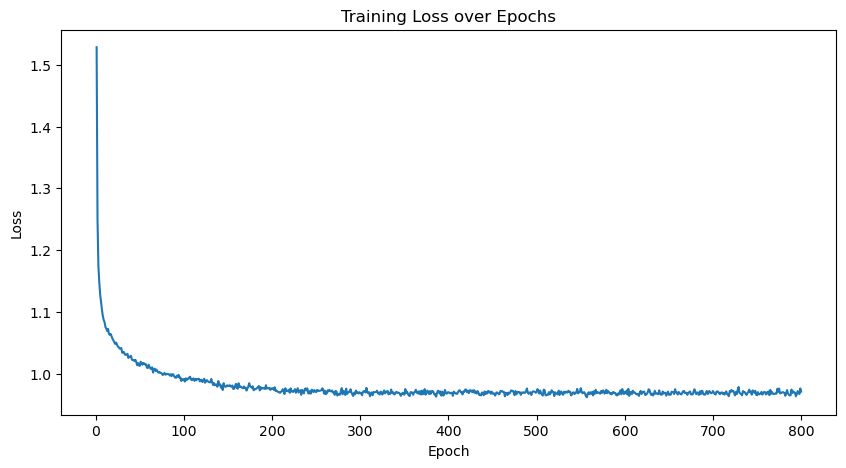

In [288]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [289]:
name_of_model = 'retina_segmentation_model_with_patch_1.pth'

In [290]:
torch.save(model.state_dict(), name_of_model)

In [291]:
test_input = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/test'


/var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_2018/863668951.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(name_of_model

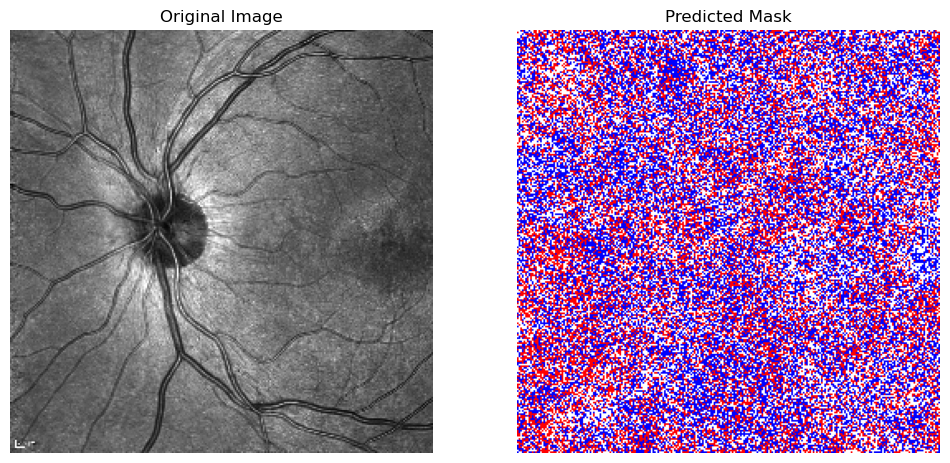

In [292]:
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define your model
num_classes = 3 

# Define your loss function
criterion = FocalDiceLoss(num_classes=num_classes, alpha=alpha, gamma=gamma, smooth=smooth)
# criterion = MultiClassDiceLoss(num_classes=num_classes)
# criterion = nn.CrossEntropyLoss()

# Re-initialize and load the trained model
model = INRSegmentationModel(num_classes=num_classes, hidden_dim=hidden_dim, num_layers=num_layers, outermost_linear=outer_layer_linear, num_freqs=num_freq, linear_network=linear_network).to(device)
model.load_state_dict(torch.load(name_of_model))
model.eval()
device = 'mps'
model.to(device)

# Initialize the Patcher
patcher = Patcher((258, 258))  # Use the same patch size used during training

def generate_coords_intensities(image_patch, device):
    """
    Genera coordinate e intensità per una data patch di immagine, spostando tutto sul device specificato.
    """
    C, H, W = image_patch.shape  # C dovrebbe essere 1

    # Crea una griglia di coordinate e spostala sul device
    y_coords, x_coords = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
    coords = torch.stack((x_coords, y_coords), dim=-1).view(-1, 2)  # Forma: (H*W, 2)

    # Normalizza le coordinate tra 0 e 1 e spostale sul device
    coords = coords.float() / torch.tensor([W - 1, H - 1], dtype=torch.float32, device=device)

    # Ottieni intensità e spostale sul device
    intensities = image_patch.view(-1).to(device)  # Forma: (H*W,)
    intensities = intensities.unsqueeze(-1)  # Forma: (H*W, 1)

    # Combina coordinate e intensità e spostale sul device
    coords_intensities = torch.cat([coords, intensities], dim=-1).to(device)  # Forma: (H*W, 3)

    return coords_intensities


def visualize_segmentation_mask(mask, title):
    """
    Visualizes the segmentation mask using Matplotlib.
    
    Args:
    mask (numpy.ndarray): 2D array of shape (H, W) with values 0, 1, or 2
    """
    # Define color mapping
    color_mapping = {
        0: [255, 255, 255], # White
        1: [0, 0, 255],     # Blue
        2: [255, 0, 0]      # Red
    }

    # Create an RGB image from the mask
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_value, color in color_mapping.items():
        rgb_image[mask == class_value] = color

    # Normalize the RGB values to the range [0, 1] for matplotlib
    rgb_image = rgb_image / 255.0

    # Display the image
    plt.imshow(rgb_image)
    plt.axis('off')  # Hide the axes
    plt.title(title)

def evaluate_model(model, image, img_size, save_path=None, image_name=None):
    model.eval()  # Imposta il modello in modalità valutazione

    # Converti l'immagine in tensore
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Aggiungi dimensione del canale

    # Applica il patching all'immagine di test
    patches_image, _ = patcher.patch(image_tensor)

    coords_intensities_list = []
    patch_sizes = []
    for img_patch in patches_image:
        # Assicurati che img_patch abbia la forma (C, H, W)
        if img_patch.dim() == 2:
            img_patch = img_patch.unsqueeze(0)  # Forma: (1, H, W)

        coords_intensities = generate_coords_intensities(img_patch, device='mps')
        coords_intensities_list.append(coords_intensities)
        patch_sizes.append((img_patch.shape[1], img_patch.shape[2]))  # Salva H, W per ogni patch

    # Concatenazione di tutte le coords_intensities
    coords_intensities = torch.cat(coords_intensities_list, dim=0).to(device)

    with torch.no_grad():
        # Inferenza del modello
        outputs = model(coords_intensities)  # Forma: (total_points, num_classes)

        # Ottieni le etichette predette
        predicted_labels = outputs.argmax(dim=-1)  # Forma: (total_points,)

    # Ricostruisci le patch predette dalle etichette predette
    start = 0
    predicted_patches = []
    for size in patch_sizes:
        H, W = size
        num_pixels = H * W
        patch_labels = predicted_labels[start:start + num_pixels]
        patch_labels = patch_labels.view(H, W)
        predicted_patches.append(patch_labels)
        start += num_pixels

    # Converti la lista di predicted_patches in un tensore
    predicted_patches_tensor = torch.stack(predicted_patches)  # Forma: (num_patches, H, W)

    # Aggiungi la dimensione del canale
    predicted_patches_tensor = predicted_patches_tensor.unsqueeze(1)  # Forma: (num_patches, 1, H, W)

    # **Converti in float prima dell'unpatching**
    predicted_patches_tensor = predicted_patches_tensor.float()

    # Unpatch della maschera predetta
    predicted_mask = patcher.unpatch(predicted_patches_tensor, img_size)

    # **Riconverti la maschera predetta in interi**
    predicted_mask = predicted_mask.long()

    # Sposta su CPU e converti in numpy array
    predicted_mask = predicted_mask.cpu().numpy()

    # Converti predicted_mask in uint8
    predicted_mask = predicted_mask.astype(np.uint8)

    # Salva o visualizza la maschera predetta
    if save_path is not None and image_name is not None:
        output_mask_path = os.path.join(save_path, f"{image_name}_predicted_mask.png")
        cv2.imwrite(output_mask_path, predicted_mask)
        print(f"Saved predicted mask to: {output_mask_path}")
    else:
        # Visualizza l'immagine originale e la maschera predetta affiancate
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Nascondi gli assi
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        visualize_segmentation_mask(predicted_mask.squeeze(), title="Predicted Mask")

        plt.show()




# Example of how to call the evaluation function on a single test image

test_image_path = os.path.join(test_input, '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/test/IR_Case_006.png')

# Load the image (assuming grayscale)
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to the original input size (768x768)
test_image = cv2.resize(test_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# Evaluate the model on the test image
evaluate_model(model, test_image, (256, 256))

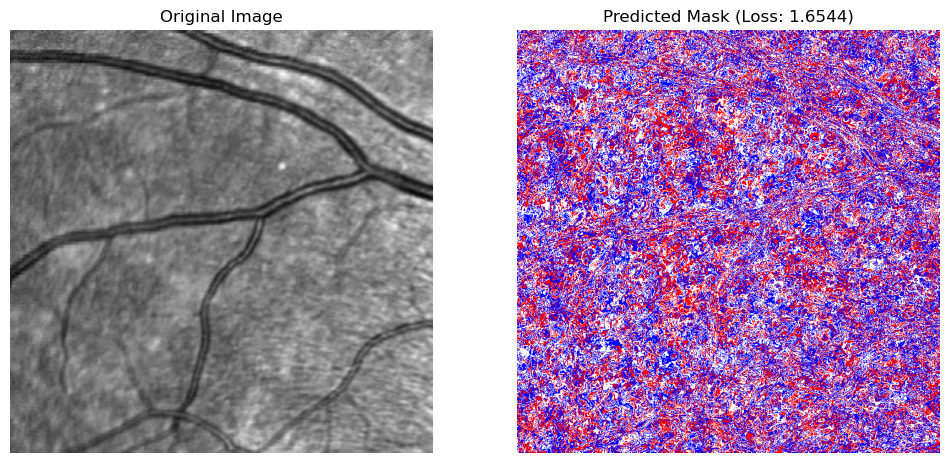

In [293]:
def evaluate_model_2(model, image, ground_truth_mask, img_size, save_path=None, image_name=None):
    model.eval()  # Imposta il modello in modalità valutazione

    # Converti l'immagine in tensore
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Aggiungi dimensione del canale

    # Applica il patching all'immagine di test
    patches_image, _ = patcher.patch(image_tensor)

    coords_intensities_list = []
    patch_sizes = []
    for img_patch in patches_image:
        # Assicurati che img_patch abbia la forma (C, H, W)
        if img_patch.dim() == 2:
            img_patch = img_patch.unsqueeze(0)  # Forma: (1, H, W)

        coords_intensities = generate_coords_intensities(img_patch, device=device)
        coords_intensities_list.append(coords_intensities)
        patch_sizes.append((img_patch.shape[1], img_patch.shape[2]))  # Salva H, W per ogni patch

    # Concatenazione di tutte le coords_intensities
    coords_intensities = torch.cat(coords_intensities_list, dim=0).to(device)

    with torch.no_grad():
        # Inferenza del modello
        outputs = model(coords_intensities)  # Forma: (total_points, num_classes)

        # Ottieni le etichette predette
        predicted_labels = outputs.argmax(dim=-1)  # Forma: (total_points,)

    # Ricostruisci le patch predette dalle etichette predette
    start = 0
    predicted_patches = []
    for size in patch_sizes:
        H, W = size
        num_pixels = H * W
        patch_labels = predicted_labels[start:start + num_pixels]
        patch_labels = patch_labels.view(H, W)
        predicted_patches.append(patch_labels)
        start += num_pixels

    # Converti la lista di predicted_patches in un tensore
    predicted_patches_tensor = torch.stack(predicted_patches)  # Forma: (num_patches, H, W)

    # Aggiungi la dimensione del canale
    predicted_patches_tensor = predicted_patches_tensor.unsqueeze(1)  # Forma: (num_patches, 1, H, W)

    # **Converti in float prima dell'unpatching**
    predicted_patches_tensor = predicted_patches_tensor.float()

    # Unpatch della maschera predetta
    predicted_mask = patcher.unpatch(predicted_patches_tensor, img_size)

    # **Riconverti la maschera predetta in interi**
    predicted_mask = predicted_mask.long()

    # Sposta su CPU e converti in numpy array
    predicted_mask_np = predicted_mask.cpu().numpy()

    # Converti predicted_mask in uint8
    predicted_mask_np = predicted_mask_np.astype(np.uint8)

    # Trasforma la maschera di ground truth in tensore
    ground_truth_mask_tensor = torch.tensor(ground_truth_mask, dtype=torch.long).view(-1).to(device)

    # Calcola la loss
    # criterion = nn.CrossEntropyLoss()  # Assicurati di usare la stessa loss usata durante l'addestramento
    criterion = FocalDiceLoss(num_classes=num_classes, alpha=alpha, gamma=gamma, smooth=smooth)
    # criterion = MultiClassDiceLoss(num_classes=num_classes)
    # criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, ground_truth_mask_tensor)

    # Converti la loss in valore scalare per visualizzarla
    loss_value = loss.item()

    # Salva o visualizza la maschera predetta
    if save_path is not None and image_name is not None:
        output_mask_path = os.path.join(save_path, f"{image_name}_predicted_mask.png")
        cv2.imwrite(output_mask_path, predicted_mask_np)
        print(f"Saved predicted mask to: {output_mask_path}")
    else:
        # Visualizza l'immagine originale e la maschera predetta affiancate
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Nascondi gli assi
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        title_with_loss = f"Predicted Mask (Loss: {loss_value:.4f})"
        visualize_segmentation_mask(predicted_mask_np.squeeze(), title=title_with_loss)

        plt.show()


# Percorso all'immagine di test e alla sua maschera di ground truth
# test_image_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/training_images/IR_Case_011.png'
# test_mask_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/training_masks/IR_Case_011.png'  # Aggiorna con il percorso corretto

test_image_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/patch_images/IR_Case_011_patch_0.png'
test_mask_path = '/Users/Q540900/Desktop/Werkstudent/RAVIR Dataset/train/patch_masks/IR_Case_011_patch_0.png'  # Aggiorna con il percorso corretto

# Carica l'immagine e la maschera di ground truth
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)

# Ridimensiona se necessario
test_image = cv2.resize(test_image, (768, 768), interpolation=cv2.INTER_LINEAR)
test_mask = cv2.resize(test_mask, (768, 768), interpolation=cv2.INTER_NEAREST)

# Trasforma la maschera se necessario (ad esempio, mappando i valori 0, 128, 255 a 0, 1, 2)
def transform_mask(mask):
    mask_transformed = np.zeros_like(mask)
    mask_transformed[mask == 0] = 0
    mask_transformed[mask == 128] = 1
    mask_transformed[mask == 255] = 2
    return mask_transformed

test_mask = transform_mask(test_mask)

# Trasforma la maschera
test_mask = transform_mask(test_mask)

# Valuta il modello sull'immagine di test
evaluate_model_2(model, test_image, test_mask, (768, 768))


1) not include the sinelayer everytime
2) plays with the scheduler --> avoid local minima
3) not normalize --> avoid smooth convergence 
4) add augmentation techniques 
5) different retina dataset --> https://paperswithcode.com/dataset/hrf

In [294]:
print(f"Num of layers = {num_layers}")
print(f"Outer linear layer = {outer_layer_linear}")
print(f"Augmented = {augment_bool}")
print(f"Batch Size = {batch_size}")
print(f"Linear Network = {linear_network}")

Num of layers = 4
Outer linear layer = False
Augmented = False
Batch Size = 64
Linear Network = False


meeting on 05.07

1. CrossEntropy or DiceLoss or FocalLoss

In [295]:

# dice loss  2.1840 -->  6 layer, outer layer true, augmentation false, num_freq = 10, batch size = 16, bias = +0.5, learning rate 1e-2
# dice loss  1.2482 -->  6 layer, outer layer true, augmentation false, num_freq = 10, batch size = 16, bias = +0.5, learning rate 1e-3
### ---> learning rate 1e-3 looks better

# dice loss  1.3685 -->  3 layer, outer layer true, augmentation false, num_freq = 10, batch size = 16, bias = +0.5, learning rate 1e-3
# dice loss  1.3324 -->  3 layer, outer layer true, augmentation false, num_freq = 10, batch size = 64, bias = +0.5, learning rate 1e-3
### ---> batch size better

# dice loss   -->  3 layer, outer layer false, augmentation false, num_freq = 10, batch size = 16, bias = softmax, learning rate 1e-3
# dice loss   1.1937-->  6 layer, outer layer false, augmentation false, num_freq = 10, batch size = 16, bias = softmax, learning rate 1e-3
# dice loss   0.9873 -->  9 layer, outer layer false, augmentation false, num_freq = 10, batch size = 16, bias = softmax, learning rate 1e-3
# dice loss    0.91 -->  9 layer, outer layer false, augmentation false, num_freq = 10, batch size = 16, bias = softmax, learning rate 1e-3, con DROPOUT --> full white

### ---> more layers, migliore, arrivati a 9 layer é uno schifo



## layer tutti lineari
# 1.2910 --> 3 layers
# --> 6 layers

# 1.3932 --> alpha 0.8 gamma 2
# 1.8159 --> alpha 0.5 gamma 2
# 1.2694 --> alpha 0.5 gamma 3, 30 freq
# 1.3593 --> alpha 0.5 gamma 3, 10 freq
# 1.1874 --> alpha 0.5 gamma 0.5, 30 freq

# 1.6527 --> alpha 0.5 gamma 0.5, 30 freq, smooth 1
# 1. --> alpha 0.5 gamma 0.5, 30 freq, smooth 1e-3



